<a href="https://colab.research.google.com/github/nicolycosta/RedesNeurais-SeriesTemporais/blob/main/RNIPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Webscrapping
!mkdir downloads #cria uma pasta chamada downloads
import ssl #necessário para o MDIC, erro caso acessar sem certificados
import urllib.request #necessário para downloads

#neuralprophet
!pip install neuralprophet[live]
from neuralprophet import NeuralProphet

#Análise e exploração de dados
!pip install xlrd==1.2.0
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 74 kB 1.7 MB/s 
     |████████████████████████████████| 172 kB 45.3 MB/s 
     |████████████████████████████████| 793 kB 49.2 MB/s 
     |████████████████████████████████| 792 kB 38.3 MB/s 
     |████████████████████████████████| 792 kB 35.7 MB/s 
     |████████████████████████████████| 791 kB 56.5 MB/s 
     |████████████████████████████████| 790 kB 52.1 MB/s 
     |████████████████████████████████| 788 kB 44.3 MB/s 
     |████████████████████████████████| 787 kB 70.9 MB/s 
     |████████████████████████████████| 786 kB 41.3 MB/s 
     |████████████████████████████████| 786 kB 43.1 MB/s 
     |████████████████████████████████| 785 kB 46.1 MB/s 
     |████████████████████████████████| 785 kB 43.3 MB/s 
     |████████████████████████████████| 785 kB 37.8 MB/s 
     |████████████████████████████████| 785 kB 44.1 MB/s 
     |████████████████████████████████| 785 kB 41.0 MB/s 
     |████████████████████████████████| 784 kB 47.0 MB/s 
     |██████████

Como os dados são extraídos diretamente da internet, prestar atenção na atualização dos meses!

# **Extração de dados da web**

In [138]:
#Download do Consumo comercial de energia elétrica no estado do Pará

ssl._create_default_https_context = ssl._create_unverified_context #certificado
filenamepath = 'downloads/energia.xlsx' 
link = 'https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/PublicacoesArquivos/publicacao-190/CONSUMO%20MENSAL%20DE%20ENERGIA%20EL%C3%89TRICA%20POR%20CLASSE.xls'
urllib.request.urlretrieve(link, filenamepath) #baixando no Arquivos
df = pd.read_excel(filenamepath, sheet_name = 'CONSUMO COMERCIAL POR UF')

# **Tratamento dos dados**

In [139]:
df = df.iloc[3:,:] #retirando linhas
df = df.T #transpondo
df[3] = df[3].fillna(method="ffill")
df[3][0]= "Ano" 
df[4][0]= "Mes" 
df.columns = df.iloc[0]
df = df.reset_index(drop = True)
df.drop([0], inplace = True)
df = df.reset_index(drop = True)

In [140]:
lista = []
for item in df["Ano"].unique():
  lista.append(range(1,13))   # para cada ano que tem no dataframe ele conta de 1 até 12, e appenda na lista
  #for each year in the dataframe, it counts from one to twelve and appends it to the lista
listao = []
for item in lista:
  for subitem in item:
    listao.append(subitem)#desempacota as listas dentro das listas
    #get each item inside each list inside the lista variable and appends it to listao
listao = listao[:len(df)] #corta os meses que não tem, limitando baseado no tamanho do dataframe.
mesnew = []
for item in listao:
  mesnew.append(f"{item:02}") #mudando o formato para string e padronizando para dois digitos.
df['Mes'] = mesnew
df['Ano'] = df['Ano'].astype(str).str.replace('*','')  #converte a coluna para string, para usar o comando replace de strings, visto que a coluna tinha dtypes misturados
df['data'] = df['Ano'] + df['Mes']
df.drop(columns = ['Ano', 'Mes'], inplace = True)
df = df.set_index('data')
df = df.iloc[:,:-1]
df = df.dropna(axis=0)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  from ipykernel import kernelapp as app



In [144]:
serie = df['Pará']
serie = pd.DataFrame(data=serie)
serie = serie.rename_axis('data').reset_index() #tirar do index para alterar o formato
serie['data'] = pd.to_datetime(serie['data'], format='%Y%m')
serie = serie.set_index('data')
serie.head()

,Pará
data,
2004-01-01,78075.21
2004-02-01,72466.75
2004-03-01,75856.86
2004-04-01,78778.78
2004-05-01,79714.3


# **Análise Exploratória**

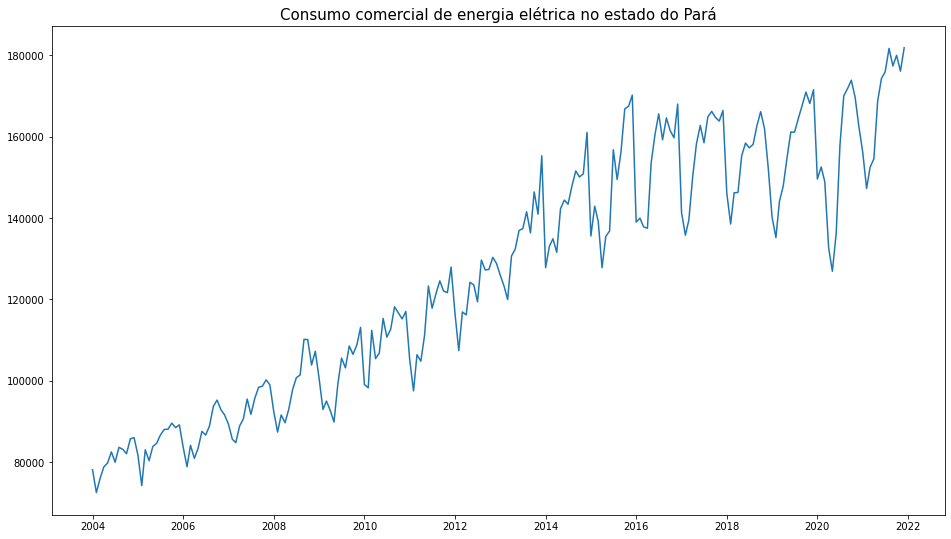

In [145]:
plt.figure(figsize=(16,9))

plt.plot()
plt.plot(serie)
plt.title('Consumo comercial de energia elétrica no estado do Pará',fontsize=15)

plt.show()

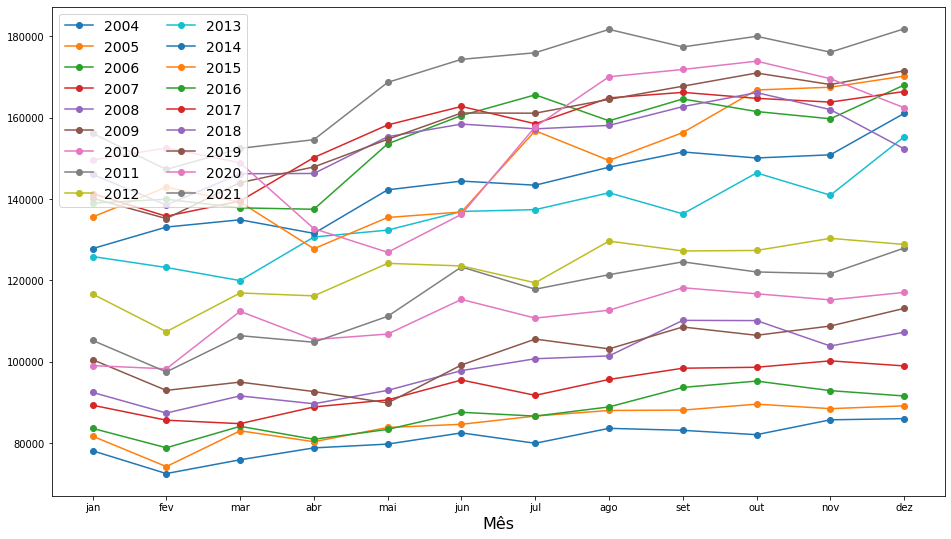

In [146]:
anos = serie.index.year.unique()
meses = serie.index.month.unique()
mesesStr = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']

plt.figure(figsize = (16,9))

for i in anos:
    ZtAno = serie[(serie.index.year == i)]
    nMeses = len(ZtAno)
    plt.plot(mesesStr[0:nMeses], ZtAno, 'o-', label = str(i))

plt.xlabel('Mês',fontsize=16)
plt.legend(loc = 'upper left', prop = {'size': 14}, ncol = 2)

plt.show()

# **Separação em treino e teste**

In [149]:
# NeuralProbhet espera uma coluna ds e uma y.
serieNova = serie.copy()
serieNova = serieNova.rename_axis('data').reset_index()
serieNova.columns = ['ds', 'y']
serieNova 

,ds,y
0,2004-01-01,78075.21
1,2004-02-01,72466.75
2,2004-03-01,75856.86
3,2004-04-01,78778.78
4,2004-05-01,79714.3
...,...,...
211,2021-08-01,181711.98
212,2021-09-01,177392.31
213,2021-10-01,180006.38
214,2021-11-01,176108


In [150]:
nSamples = len(serieNova) 
nTestSamples = 12     
nModelSamples = nSamples - nTestSamples

print(f'Número de amostras: {nSamples}')
print(f'Número de amostras para treino: {nModelSamples}')
print(f'Número de amostras para teste: {nTestSamples}')

Train = serieNova.iloc[:nModelSamples]
Test = serieNova.iloc[nModelSamples:]


Número de amostras: 216
Número de amostras para treino: 204
Número de amostras para teste: 12


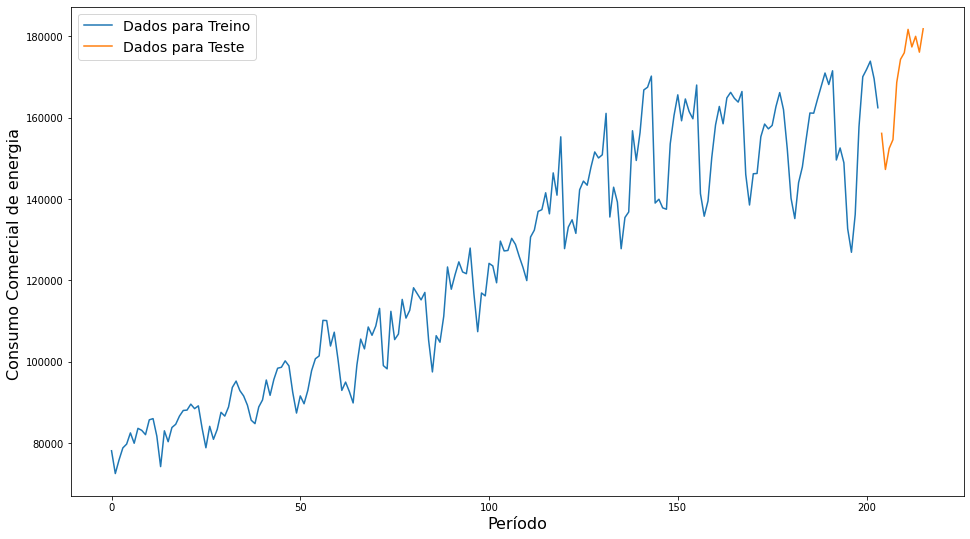

In [151]:
plt.figure(figsize = (16, 9))

plt.plot(Train['y'], label = 'Dados para Treino')
plt.plot(Test['y'], label = 'Dados para Teste')
plt.legend(loc = 'upper left', prop = {'size': 14})
plt.xlabel('Período',fontsize=16)
plt.ylabel('Consumo Comercial de energia ',fontsize=16)

plt.show()


# **NeuralProphet**
#### NeuralProphet é uma versão atualizada do Prophet
Usando o mecanismo de otimização Gradient Descent do PyTorch

In [152]:
modeladd = NeuralProphet(seasonality_mode="additive",
                      epochs= 600)
modelmul = NeuralProphet(seasonality_mode="multiplicative",
                      epochs= 600)

# **Teste** 

In [153]:
modeladd.fit(Train, freq= 'M')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.176% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.88E-02, min: 2.39E+00


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.88E-02, min: 1.13E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.80E-02
Epoch[600/600]: 100%|██████████| 600/600 [00:18<00:00, 31.92it/s, SmoothL1Loss=0.00156, MAE=4.04e+3, RMSE=5.13e+3, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.509530,87612.637408,100519.640012,0.0
1,0.489583,85427.816023,97380.607843,0.0
2,0.469481,83201.740962,95649.448376,0.0
3,0.449558,80974.040901,93299.360294,0.0
4,0.428402,78592.607230,90848.109222,0.0
...,...,...,...,...
595,0.001563,4041.892267,5182.350208,0.0
596,0.001562,4041.517894,5204.587824,0.0
597,0.001562,4041.404029,5148.571940,0.0
598,0.001562,4041.300638,5171.185173,0.0


In [154]:
modelmul.fit(Train, freq= 'M')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.176% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.88E-02, min: 5.37E-01


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.88E-02, min: 4.45E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.80E-02
Epoch[600/600]: 100%|██████████| 600/600 [00:20<00:00, 28.91it/s, SmoothL1Loss=0.00123, MAE=3.51e+3, RMSE=4.59e+3, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.698175,104310.428309,135362.063419,0.0
1,0.669299,101161.663603,132094.412990,0.0
2,0.641951,98172.565564,126757.406556,0.0
3,0.613724,95124.804075,125851.948836,0.0
4,0.586232,92049.780025,122324.938572,0.0
...,...,...,...,...
595,0.001230,3510.209750,4597.206179,0.0
596,0.001230,3510.369983,4479.177342,0.0
597,0.001230,3510.442593,4424.016520,0.0
598,0.001230,3510.376757,4540.340954,0.0


De acordo com os critérios de decisão MAE e RMSE, o modelo que mais de adequa a série, é com o parâmetro Multiplicativo.

In [155]:
pred = modelmul.make_future_dataframe(Train, periods = 12)
forecast = modelmul.predict(pred)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.176% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M


,ds,y,yhat1,residual1,trend,season_yearly
0,2020-12-31,None,144054.203125,NaN,155224.406250,-0.134975
1,2021-01-31,None,141435.531250,NaN,155214.765625,-0.166520
2,2021-02-28,None,144000.875000,NaN,155206.046875,-0.135427
3,2021-03-31,None,142833.125000,NaN,155196.390625,-0.149442
4,2021-04-30,None,148730.375000,NaN,155187.062500,-0.078054


In [156]:
forecast_serie = forecast[['ds','yhat1']].set_index('ds').squeeze()
TestDataFrame = Test[['ds','y']].set_index('ds').squeeze()
TrainDataFrame = Train[['ds','y']].set_index('ds').squeeze()

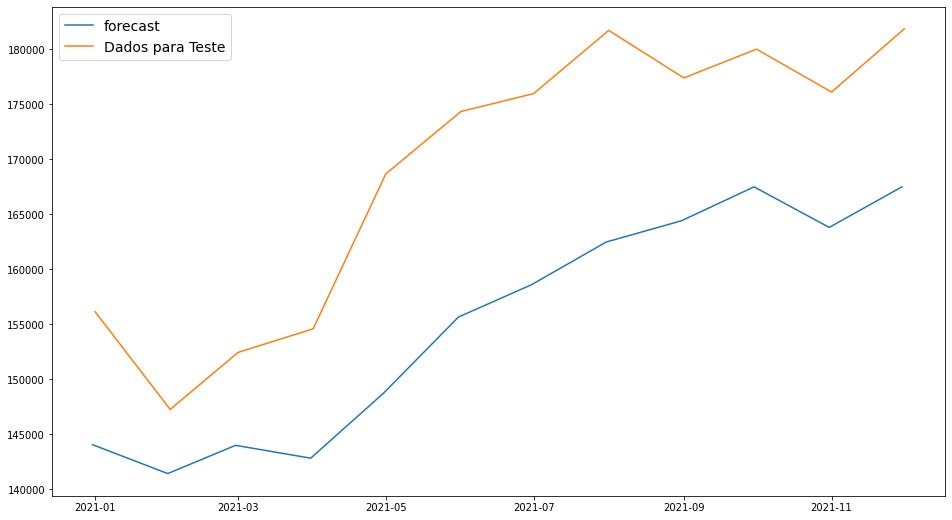

In [157]:
plt.figure(figsize = (16, 9))

plt.plot(forecast_serie, label = 'forecast')
plt.plot(TestDataFrame, label = 'Dados para Teste')
plt.legend(loc = 'upper left', prop = {'size': 14})

plt.show()

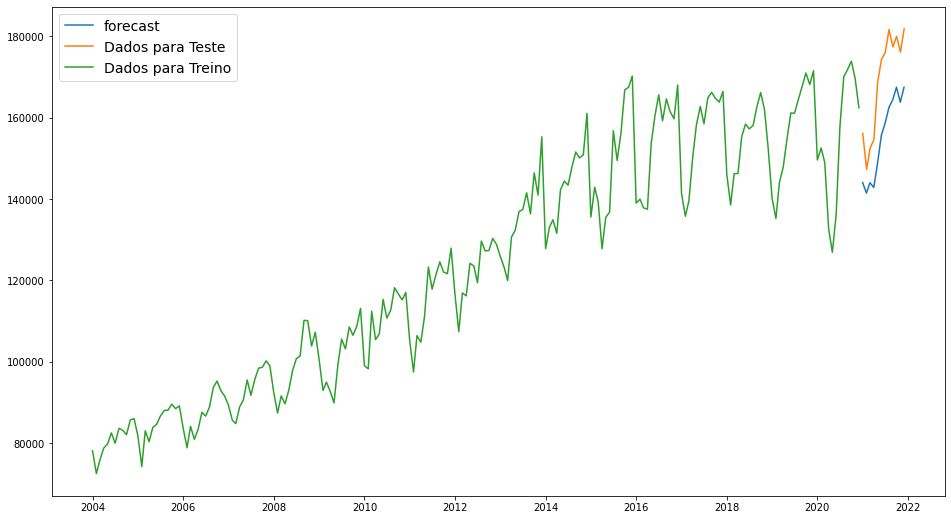

In [158]:
plt.figure(figsize = (16, 9))

plt.plot(forecast_serie, label = 'forecast')
plt.plot(TestDataFrame, label = 'Dados para Teste')
plt.plot(TrainDataFrame, label = 'Dados para Treino')
plt.legend(loc = 'upper left', prop = {'size': 14})

plt.show()

# **Projeção para 12 meses/ 1 ano a frente**

In [159]:
predição = modelmul.make_future_dataframe(serieNova, periods = 12)
prediçãofinal = modelmul.predict(predição)
prediçãofinal

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.204% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M


,ds,y,yhat1,residual1,trend,season_yearly
0,2021-12-31,None,143988.218750,NaN,155110.750000,-0.134584
1,2022-01-31,None,141399.625000,NaN,155101.093750,-0.165808
2,2022-02-28,None,143801.921875,NaN,155092.375000,-0.136646
3,2022-03-31,None,142845.437500,NaN,155082.718750,-0.148123
4,2022-04-30,None,148422.250000,NaN,155073.390625,-0.080516
5,2022-05-31,None,155658.140625,NaN,155063.734375,0.007197
6,2022-06-30,None,158286.156250,NaN,155054.390625,0.039131
7,2022-07-31,None,162497.062500,NaN,155044.734375,0.090246
8,2022-08-31,None,164088.468750,NaN,155035.093750,0.109647
9,2022-09-30,None,167538.531250,NaN,155025.734375,0.151562


In [160]:
prediçãofinall = prediçãofinal[['ds','yhat1']].set_index('ds').squeeze()
serie = serieNova[['ds','y']].set_index('ds').squeeze()


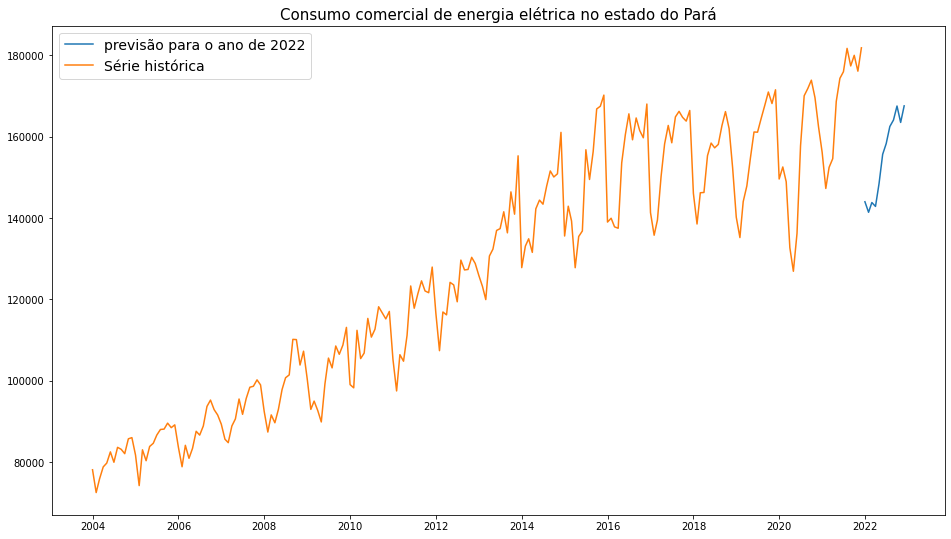

In [161]:
plt.figure(figsize = (16, 9))

plt.plot(prediçãofinall, label = 'previsão para o ano de 2022')
plt.plot(serie, label = 'Série histórica')
plt.legend(loc = 'upper left', prop = {'size': 14})
plt.title('Consumo comercial de energia elétrica no estado do Pará',fontsize=15)

plt.show()

https://blog.katastros.com/a?ID=d5e2e8a8-e971-4db9-a5b0-e8f1dc592e89